### COPD severity classification

The dataset source: [COPD patients](https://www.kaggle.com/prakharrathi25/copd-student-dataset?select=dataset.csv).

The dataset is a cohort of patients, who had been invited to take part in a rehabilitation program to help manage their COPD. 

__Patients: 101__\
__Variables: 24__


Original dataset columns:

* Serial Number, row id.
* Unique ID, patient id.
* AGE, patient age.
* PackHistory, pack years smoking, pack years is defined as twenty cigarettes smoked every day for one year.
* COPDSEVERITY, severity of the disease.
* MWT1, distance that patient walks in 6 minutes in meters (attempt 1).
* MWT2, distance that patient walks in 6 minutes in meters (attempt 2).
* MWT1Best, distance that patient walks in 6 minutes in meters (best attempt)
* FEV1, Amount of air a patient can force from lungs in one second in litres. The measurement of the spirometer.
* FEV1PRED, FEV1 that would be predicted as normal based on a several personal factors of a patient. It is defined as FEV1% of the patient divided by the average FEV1% in the population for any person of similar age, sex, and body composition. 
* FVC, total volume of air that a patient can forcibly exhale in one breath.
* FVCPRED, FVC that would be predicted as normal based on a several personal factors of a patient.
* CAT, the COPD assessment test. It is designed to measure the impact of COPD on a person's life, and how this changes over time.
* HAD, the level of hospital anxiety and depression.
* SGRQ, quality of life index. Lower the value, higher the quality of life.
* AGEquartiles, quartiles of Age.
* copd, stage of COPD, 1-4.
* gender, females - 0 males - 1.
* smoking, whether a patinet smokes or not.
* Diabetes, whether a patinet has hypertension diabetes.
* muscular, whether a patinet has muscular distrophy.
* hypertension, whether a patinet has hypertension.
* AtrialFib, whether a patinet has arrhythmia.
* IHD, whether a patinet has ischemic heart disease.

In the notebook we will try to classify COPD severity level and prepare production-ready inference model.

The source code [GitHub link](https://github.com/alexander-pv/educational_repo/tree/master/ds_tasks/copd_severity_classificaton).

Page hyperlinks:

1. [EDA](#eda)
2. [Data preparation](#data_prep)
3. [Modelling](#modelling)
    * [Baseline](#baseline)
    * [Further models](#further_models)
    
    
4. [Hyperparameters optimization](#hyperopt)
5. [Evaluating results](#final_score)
6. [Making onnx model for production](#onnxruntime)

In [1]:
import sys
import warnings

path_append_flag = True
if path_append_flag:
    sys.path.append('../')
    path_append_flag = False

import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, log_loss, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score,\
                                    cross_val_predict, LeaveOneOut, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import hyperopt
import shap

from skl2onnx import convert_sklearn, update_registered_converter
from onnxmltools.convert.lightgbm.operator_converters.LightGbm import convert_lightgbm 
from skl2onnx.common import data_types as skl2onnx_dtype
from skl2onnx.common import shape_calculator as skl2onnx_shapecalc
from onnxmltools.convert.lightgbm.operator_converters.LightGbm import convert_lightgbm
import onnxruntime as ort

from src.config import data_info
from src import transforms as ft
from src import utils

%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,sklearn,hyperopt,lightgbm,seaborn,matplotlib,shap,skl2onnx,onnxmltools,onnxruntime -vw

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.31.0

pandas     : 1.3.4
numpy      : 1.20.3
sklearn    : 1.0.1
hyperopt   : 0.2.5
lightgbm   : 3.3.1
seaborn    : 0.11.2
matplotlib : 3.5.0
shap       : 0.38.1
skl2onnx   : 1.10.3
onnxmltools: 1.10.0
onnxruntime: 1.10.0

Watermark: 2.3.0



<a id="eda"></a>
### EDA

In [3]:
df_copd = pd.read_csv(
    data_info.copd_data.data,
    usecols=tuple(range(1, 24)),
    dtype={'ID': int, 'SGRQ': float, 'FEV1': float, 'FVC': float, 'MWT2': float, 'MWT1Best': float,
           'MWT1': float, 'FVCPRED': float, 'MWT_diff': float, 'FEV1PRED': float, 'PackHistory': float,
           'AGE': float, 'CAT': float, 'HAD':  float, 'COPDSEVERITY': str, 'AGEquartiles': object, 'copd': int,
           'gender': int, 'smoking': int, 'Diabetes': int, 'muscular': int, 'hypertension': int, 'AtrialFib': int,
           'IHD': int}
)
df_copd_origin = df_copd.copy(deep=True)

In [4]:
df_copd.columns

Index(['ID', 'AGE', 'PackHistory', 'COPDSEVERITY', 'MWT1', 'MWT2', 'MWT1Best',
       'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'HAD', 'SGRQ',
       'AGEquartiles', 'copd', 'gender', 'smoking', 'Diabetes', 'muscular',
       'hypertension', 'AtrialFib', 'IHD'],
      dtype='object')

In [5]:
df_copd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            101 non-null    int64  
 1   AGE           101 non-null    float64
 2   PackHistory   101 non-null    float64
 3   COPDSEVERITY  101 non-null    object 
 4   MWT1          99 non-null     float64
 5   MWT2          100 non-null    float64
 6   MWT1Best      100 non-null    float64
 7   FEV1          101 non-null    float64
 8   FEV1PRED      101 non-null    float64
 9   FVC           101 non-null    float64
 10  FVCPRED       101 non-null    float64
 11  CAT           101 non-null    float64
 12  HAD           101 non-null    float64
 13  SGRQ          101 non-null    float64
 14  AGEquartiles  101 non-null    object 
 15  copd          101 non-null    int64  
 16  gender        101 non-null    int64  
 17  smoking       101 non-null    int64  
 18  Diabetes      101 non-null    

* 2 missing values for MWT1
* 1 missing value for MWT2, MWT1Best

In [6]:
df_copd.describe()

,ID,AGE,PackHistory,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,...,HAD,SGRQ,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
count,101.000000,101.00000,101.000000,99.000000,100.000000,100.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.00000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,91.405941,70.09901,39.698020,385.858586,390.280000,399.110000,1.603762,58.531485,2.954950,86.435644,...,11.180198,40.185842,2.19802,0.643564,1.841584,0.207921,0.188119,0.118812,0.198020,0.089109
std,51.516246,7.89874,24.558713,104.744199,107.754498,106.550116,0.672763,22.294821,0.976283,21.740016,...,8.588807,18.239268,0.88340,0.481335,0.366952,0.407844,0.392756,0.325181,0.400495,0.286322
min,1.000000,44.00000,1.000000,120.000000,120.000000,120.000000,0.450000,3.290000,1.140000,27.000000,...,0.000000,2.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,65.00000,20.000000,300.000000,303.750000,303.750000,1.100000,42.000000,2.270000,71.000000,...,6.000000,28.410000,2.00000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,87.000000,71.00000,36.000000,419.000000,399.000000,420.000000,1.600000,60.000000,2.770000,84.000000,...,10.000000,38.210000,2.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,143.000000,75.00000,54.000000,460.500000,459.000000,465.250000,1.960000,75.000000,3.630000,103.000000,...,15.000000,55.230000,3.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,169.000000,88.00000,109.000000,688.000000,699.000000,699.000000,3.180000,102.000000,5.370000,132.000000,...,56.200000,77.440000,4.00000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_copd.head()

,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,58,77.0,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,2.40,...,69.55,4,3,1,2,1,0,0,1,0
1,57,79.0,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,1.64,...,44.24,4,2,0,2,1,0,0,1,1
2,62,80.0,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,2.30,...,44.09,4,2,0,2,1,0,0,1,0
3,145,56.0,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,1.14,...,62.04,1,4,1,2,0,0,1,1,0
4,136,65.0,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,2.91,...,75.56,1,3,1,2,0,1,1,0,0


In [8]:
id_counts = df_copd['ID'].value_counts()
repeated_ids = id_counts[id_counts > 1]
repeated_ids

162    2
158    2
159    2
157    2
Name: ID, dtype: int64

In [9]:
df_repeats = df_copd[df_copd['ID'].isin(repeated_ids.index.tolist())]

In [10]:
df_repeats_num = df_repeats.select_dtypes(include=np.number)
df_repeats_cat = df_repeats.select_dtypes(exclude=np.number)

In [11]:
df_repeats_num

,ID,AGE,PackHistory,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,...,HAD,SGRQ,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
14,162,70.0,103.0,264.0,271.0,271.0,1.20,52.0,2.09,121.0,...,1.0,39.66,2,0,2,0,0,0,0,0
15,162,71.0,105.0,264.0,271.0,271.0,0.72,52.0,2.09,121.0,...,1.0,39.66,2,0,2,0,0,0,0,0
60,159,80.0,3.0,435.0,451.0,451.0,1.97,90.0,2.33,84.0,...,6.0,36.74,1,1,2,0,1,0,0,0
61,159,81.0,3.0,435.0,451.0,451.0,1.83,90.0,2.33,84.0,...,6.0,36.74,1,1,2,1,1,0,0,0
68,158,70.0,36.0,419.0,459.0,459.0,2.11,90.0,3.51,125.0,...,0.0,10.92,1,0,2,0,0,0,0,0
70,158,70.0,36.0,419.0,459.0,459.0,1.89,90.0,3.51,125.0,...,0.0,10.92,1,0,2,0,0,0,0,0
76,157,75.0,30.0,469.0,399.0,469.0,1.64,59.0,3.10,79.0,...,9.0,32.38,2,1,1,0,0,0,0,0
77,157,76.0,30.0,469.0,399.0,469.0,1.74,59.0,3.10,79.0,...,9.0,32.38,2,1,1,0,0,0,0,0


In [12]:
for i, j in np.array_split(range(8), 4):
    diff = df_repeats_num.iloc[j] - df_repeats_num.iloc[i]
    print(diff[diff!=0], end='\n\n')

AGE            1.00
PackHistory    2.00
FEV1          -0.48
dtype: float64

AGE           1.00
FEV1         -0.14
CAT        -170.00
Diabetes      1.00
dtype: float64

FEV1   -0.22
dtype: float64

AGE     1.0
FEV1    0.1
dtype: float64



In [13]:
df_repeats_cat

,COPDSEVERITY,AGEquartiles
14,MODERATE,2
15,MODERATE,2
60,MILD,4
61,MILD,4
68,MILD,2
70,MILD,2
76,MODERATE,4
77,MODERATE,4


3 elderly patients with __IDS={157, 159, 162}__ have an additional info for the next year after the initial data recording (difference in AGE=1).

1 elderly patient with __ID=158__ has two recordings with only difference in FEV1 parameters. Based on the data of the other 3 elderly patients discussed above it is highly likely that the second recording with row index=70 was added the next year, but the patient had not the birthday yet or it was a simple data filling mistake.

Besides, COPD severity level for these patients is stable for each measurement year. 

Since other data contains recordings for only one year, it is better to exclude this time-series related data.

In [14]:
exclude_idx = (15, 61, 70, 77)
df_copd = df_copd.loc[~df_copd.index.isin(exclude_idx)]
df_copd = df_copd.reset_index(drop=True)

In [15]:
df_copd.columns

Index(['ID', 'AGE', 'PackHistory', 'COPDSEVERITY', 'MWT1', 'MWT2', 'MWT1Best',
       'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'HAD', 'SGRQ',
       'AGEquartiles', 'copd', 'gender', 'smoking', 'Diabetes', 'muscular',
       'hypertension', 'AtrialFib', 'IHD'],
      dtype='object')

In [16]:
df_copd['MWT_diff'] = df_copd['MWT2']-df_copd['MWT1']

In [17]:
df_uncntr = pd.DataFrame(df_copd.nunique().sort_values(ascending=False))
df_uncntr['data_type'] = [x.name for x in df_copd.dtypes.values.tolist()]
df_uncntr

,0,data_type
ID,97,int64
SGRQ,89,float64
FEV1,83,float64
FVC,80,object
MWT2,72,float64
MWT1Best,71,float64
MWT1,69,float64
FVCPRED,57,float64
MWT_diff,57,float64
FEV1PRED,51,float64


Inspecting Pearson correlation matrix:

In [18]:
df_copd.select_dtypes(include=np.float64).columns.tolist()

['AGE',
 'PackHistory',
 'MWT1',
 'MWT2',
 'MWT1Best',
 'FEV1',
 'FEV1PRED',
 'FVC',
 'FVCPRED',
 'CAT',
 'HAD',
 'SGRQ',
 'MWT_diff']

In [19]:
feats = df_copd.select_dtypes(include=np.float64).columns.tolist()
df_corr = df_copd[feats].corr()
df_corr.style.background_gradient(cmap='coolwarm')

,AGE,PackHistory,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,CAT,HAD,SGRQ,MWT_diff
AGE,1.000000,0.020050,-0.264769,-0.250943,-0.246787,-0.109149,0.049395,-0.139068,0.010049,0.087825,-0.221789,-0.136886,0.028867
PackHistory,0.020050,1.000000,-0.223128,-0.259223,-0.222765,-0.095682,-0.107798,-0.082188,-0.051254,-0.143148,0.051003,0.027841,-0.138845
MWT1,-0.264769,-0.223128,1.000000,0.956664,0.982360,0.448493,0.361142,0.448286,0.285182,-0.137779,-0.275326,-0.511643,-0.033000
MWT2,-0.250943,-0.259223,0.956664,1.000000,0.983664,0.461993,0.402033,0.455896,0.321265,-0.155261,-0.294375,-0.519611,0.259467
MWT1Best,-0.246787,-0.222765,0.982360,0.983664,1.000000,0.458350,0.384360,0.442916,0.283146,-0.155837,-0.298753,-0.535302,0.118173
FEV1,-0.109149,-0.095682,0.448493,0.461993,0.458350,1.000000,0.785968,0.822779,0.552442,-0.067109,-0.160335,-0.302976,0.092564
FEV1PRED,0.049395,-0.107798,0.361142,0.402033,0.384360,0.785968,1.000000,0.535390,0.638425,0.019084,-0.088560,-0.316959,0.175369
FVC,-0.139068,-0.082188,0.448286,0.455896,0.442916,0.822779,0.535390,1.000000,0.650829,-0.160166,-0.140191,-0.216750,0.072651
FVCPRED,0.010049,-0.051254,0.285182,0.321265,0.283146,0.552442,0.638425,0.650829,1.000000,-0.123595,-0.116980,-0.273226,0.151228
CAT,0.087825,-0.143148,-0.137779,-0.155261,-0.155837,-0.067109,0.019084,-0.160166,-0.123595,1.000000,0.149229,0.279231,-0.072004


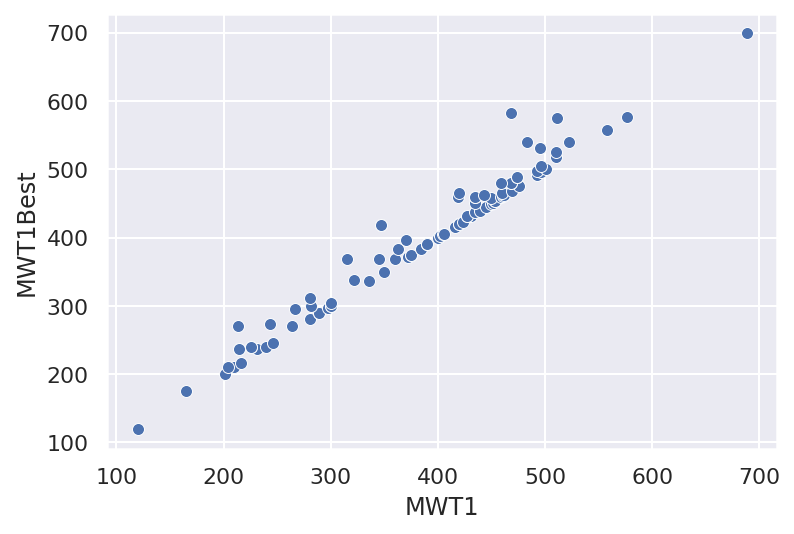

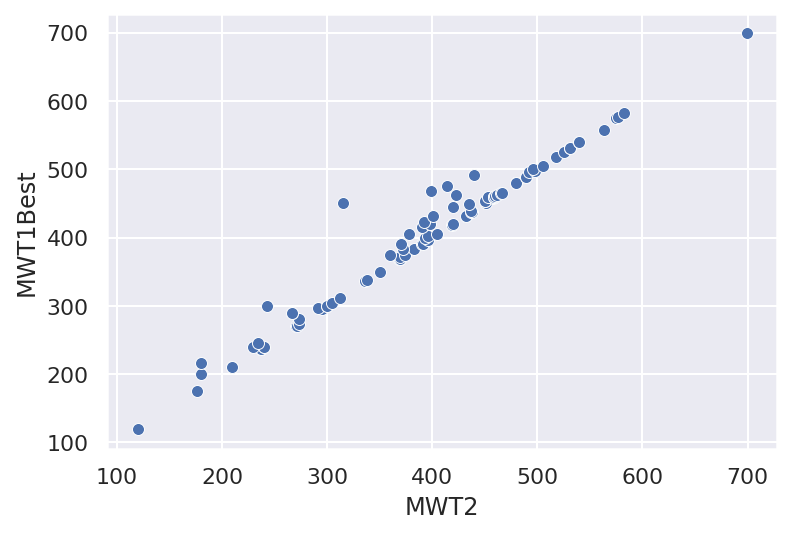

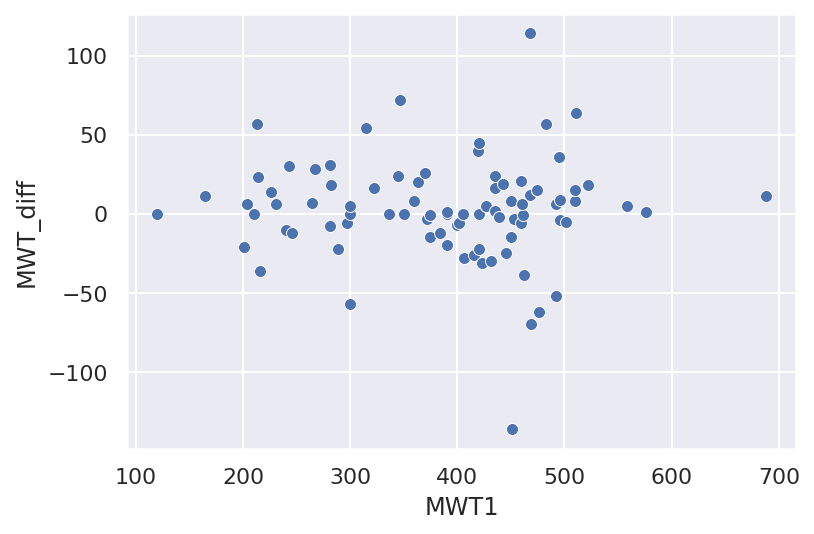

In [20]:
sns.scatterplot(data=df_copd, x='MWT1', y='MWT1Best')
plt.show()
sns.scatterplot(data=df_copd, x='MWT2', y='MWT1Best')
plt.show()
sns.scatterplot(data=df_copd, x='MWT1', y='MWT_diff')
plt.show()

MWT1, MWT2 and MWT1Best are higly correlated values. To store all the additional information about the range between the first and the second attempt of a 6 min walk, we can save only one MWT parameter and the difference between another attempt.

Intuitively, the level of endurance with a higher severity level of the disease may decrease after the first walk. Therefore, it is worth keeping the sign in the distance difference.

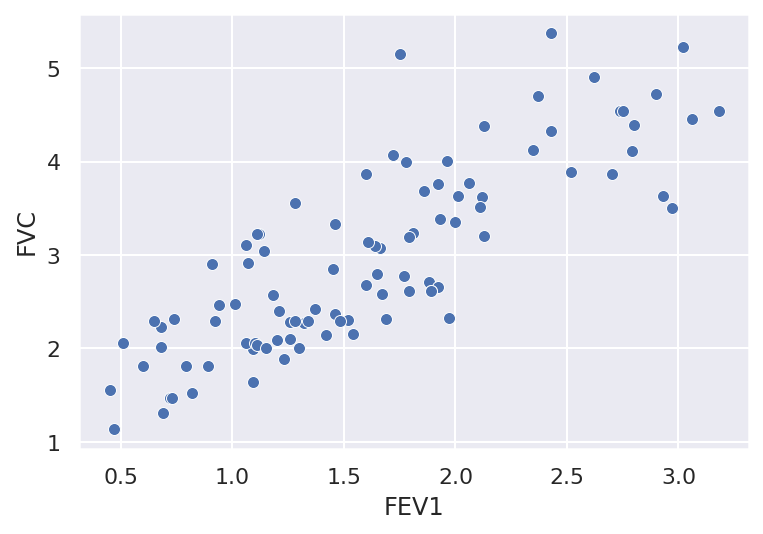

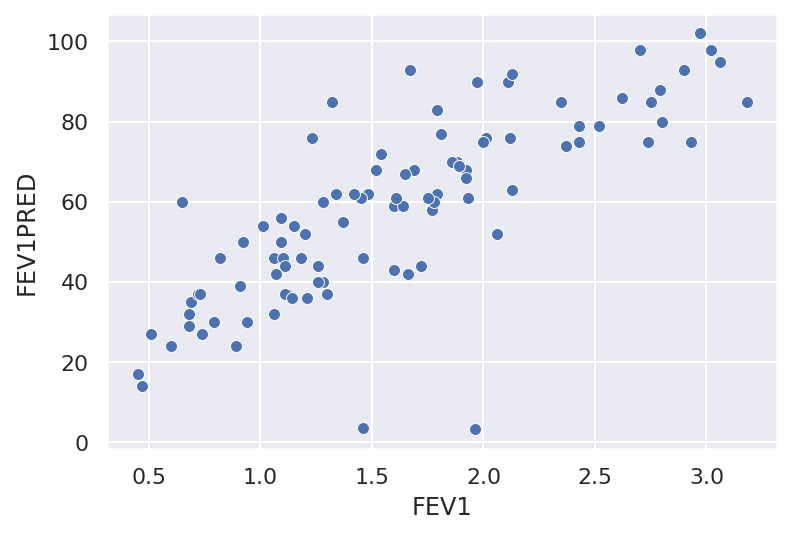

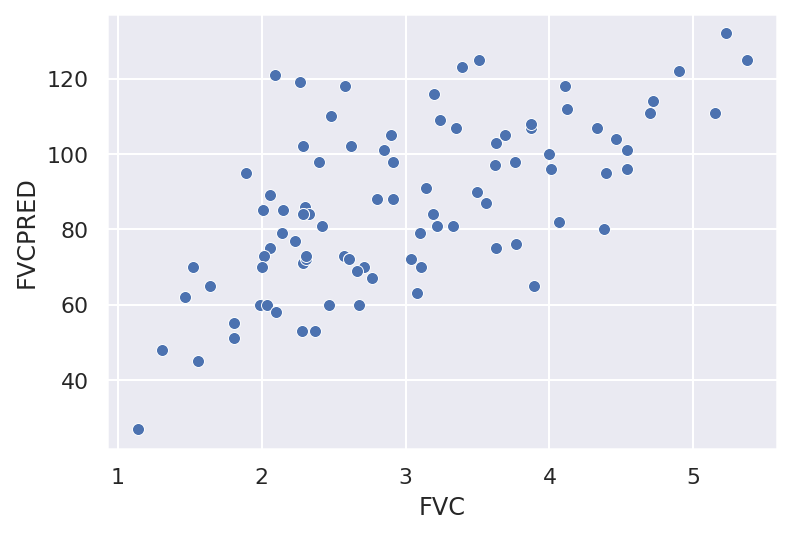

In [21]:
sns.scatterplot(data=df_copd, x='FEV1', y='FVC')
plt.show()
sns.scatterplot(data=df_copd, x='FEV1', y='FEV1PRED')
plt.show()
sns.scatterplot(data=df_copd, x='FVC', y='FVCPRED')
plt.show()
plt.show()

FEV1 and FVC features are too higly correlated. However, it is difficult to say unequivocally whether it is worth dropping an additional feature, there is a risk of losing an additional signal.
The same can be said for the age quartilies feature.

There is not a lot of data, so we can postpone the topic until the moment of feature importance analysis.

In [22]:
df_copd = df_copd.drop(columns=['ID', 'COPDSEVERITY', 'MWT2', 'MWT1Best'])

Let's also consider how separable the disease levels are if we classify them based on marginal features distributions. To do this, we will plot feature histograms (in kde) depending on the level of the disease.

In [23]:
features = df_copd.select_dtypes(include=float).columns.tolist()

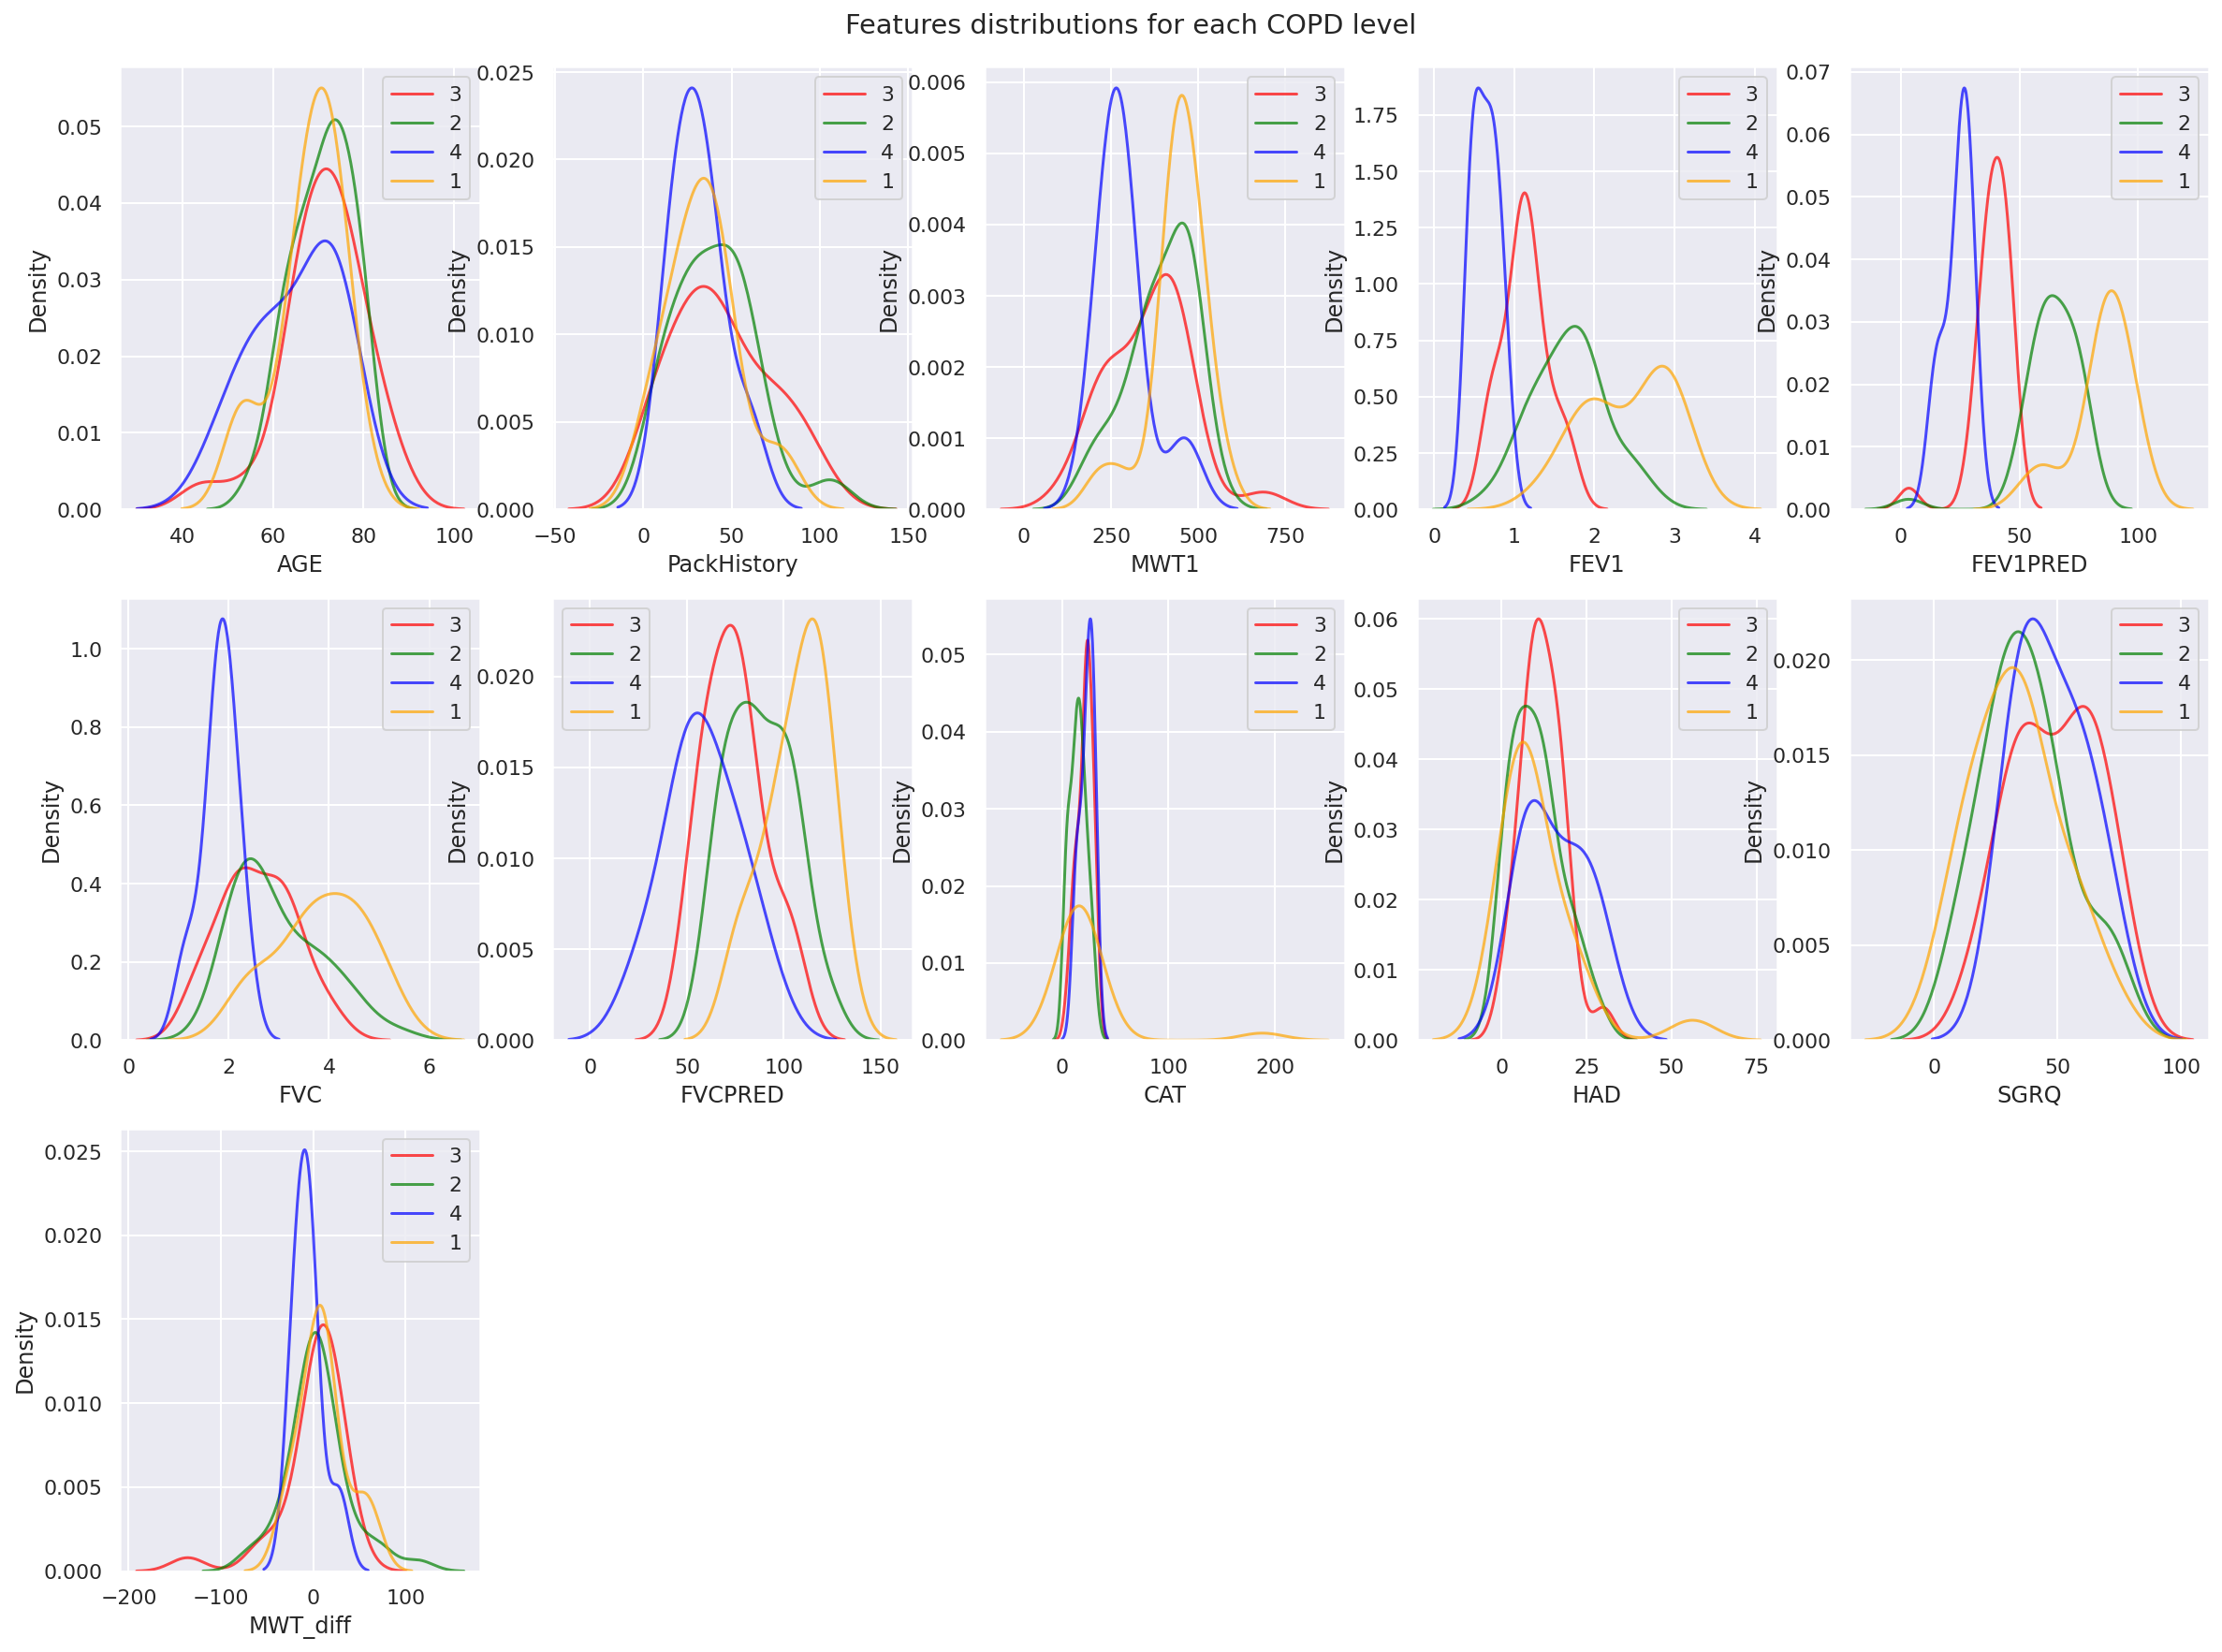

In [24]:
plt.figure(figsize=(20, 20))

for i in range(1, len(features)+1):
    fidx = i-1
    plt.subplot(4, 5, i)
    for copd_level, col in zip(df_copd['copd'].unique(), ('red', 'green', 'blue', 'orange')):
        sns.kdeplot(
            df_copd.loc[df_copd['copd'] == copd_level, features[fidx]],
            color=col,
            label=copd_level,
            alpha=0.7,
            fill=False,
            warn_singular=False
        )
    plt.legend()

plt.suptitle('Features distributions for each COPD level', x=0.5, y=0.9)
plt.show()

MWT1, FEW1(FEW1PRED, respectively), FVC are the features that has high discriminative power. However, levels 2 and 3 of the disease are quite difficult to separate well by the simple threshold with these features.

In [25]:
df_copd['copd'].value_counts()

2    41
3    27
1    21
4     8
Name: copd, dtype: int64

The dataset is quite class-imbalanced which may lead to the class 2 shift in the model predictions. So, several technique may be used to increase model accuracy, for example:
1. Oversampling
2. Class-weighted loss function

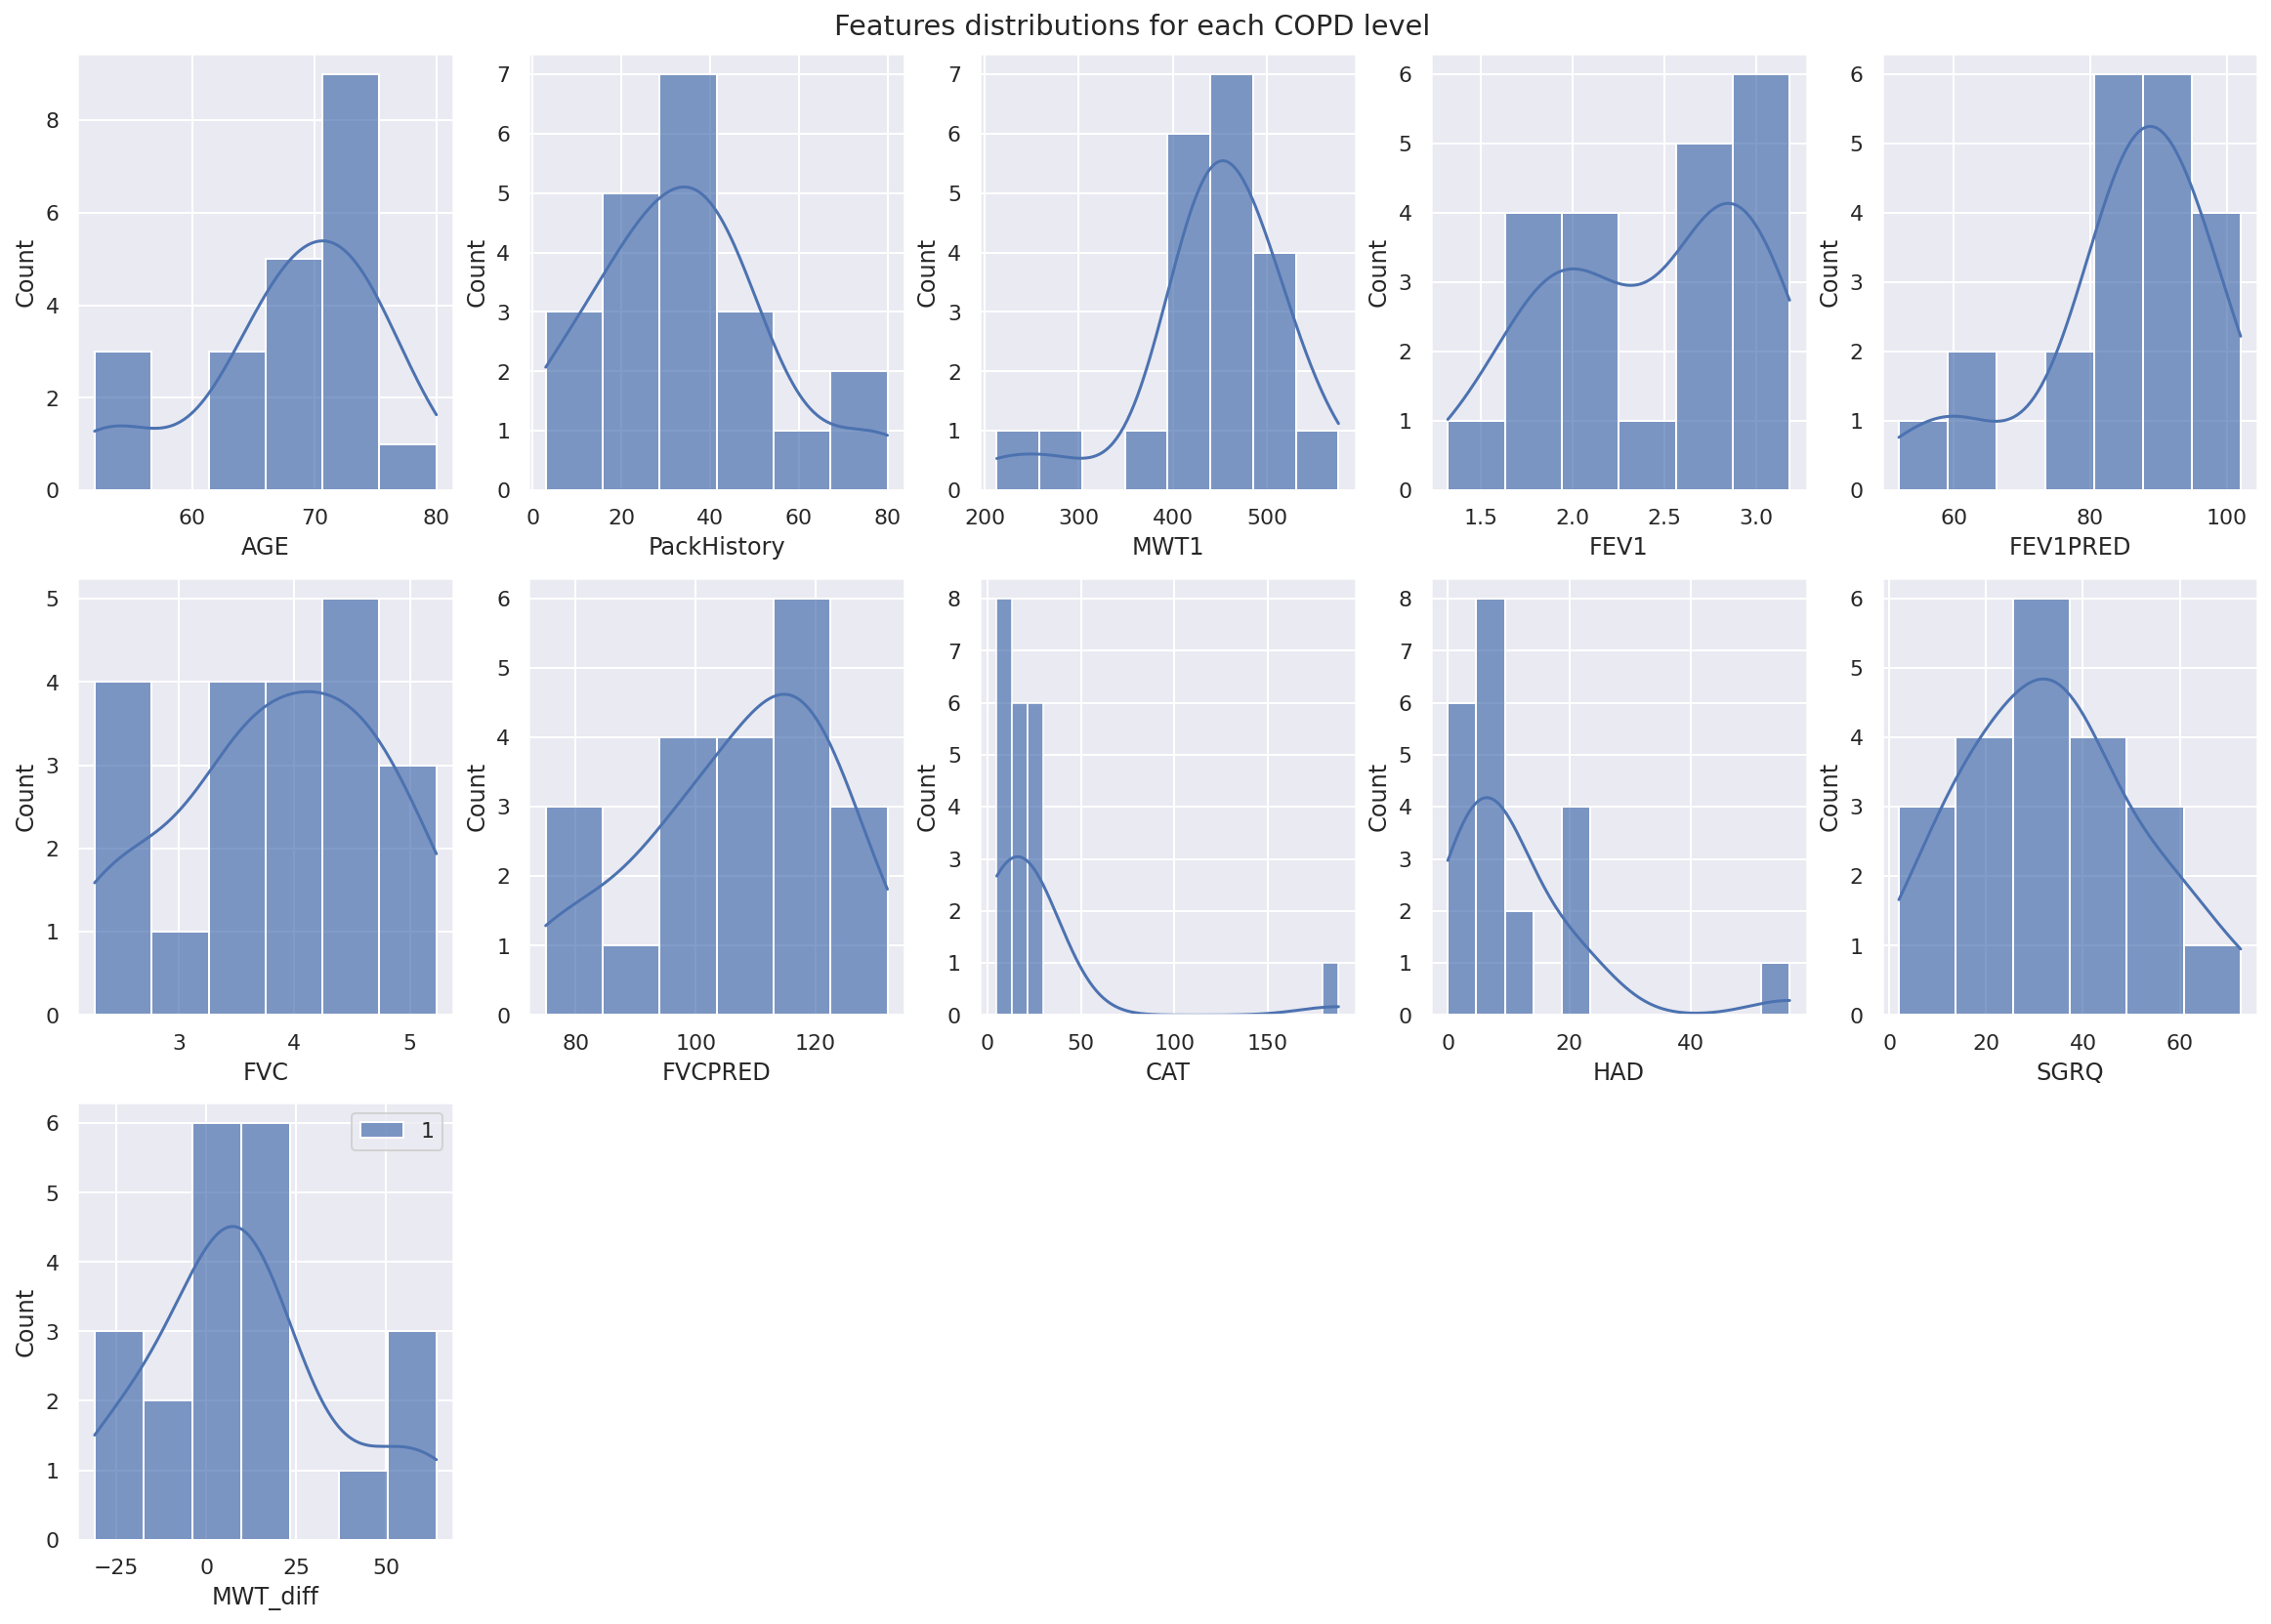

In [26]:
plt.figure(figsize=(20, 14))

for i in range(1, len(features)+1):
    fidx = i-1
    plt.subplot(3, 5, i)
    sns.histplot(
        df_copd.loc[df_copd['copd'] == copd_level, features[fidx]],
        label=copd_level,
        alpha=0.7,
        kde=True
    )
    
plt.legend()
plt.suptitle('Features distributions for each COPD level', x=0.5, y=0.9)
plt.show()

In [27]:
df_copd_origin[df_copd_origin['CAT'] > 3 * df_copd_origin['CAT'].std()]

,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
60,159,80.0,3.0,MILD,435.0,451.0,451.0,1.97,90.0,2.33,...,36.74,4,1,1,2,0,1,0,0,0


In [28]:
df_copd_origin[df_copd_origin['HAD'] > 3 * df_copd_origin['HAD'].std()]

,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
3,145,56.0,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,1.14,...,62.04,1,4,1,2,0,0,1,1,0
6,93,67.0,50.0,SEVERE,214.0,237.0,237.0,0.69,35.0,1.31,...,77.44,2,3,0,1,1,0,0,1,0
17,1,55.0,109.0,MODERATE,281.0,273.0,281.0,1.54,72.0,2.15,...,76.50,1,2,0,2,0,0,0,0,0
20,138,74.0,24.0,VERY SEVERE,267.0,295.0,295.0,0.51,27.0,2.06,...,71.21,3,4,0,2,0,0,0,0,0
25,63,80.0,67.0,MODERATE,300.0,305.0,305.0,1.77,58.0,2.77,...,67.66,4,2,1,2,0,0,0,0,0
80,18,65.0,20.0,MILD,468.0,480.0,480.0,2.13,92.0,3.20,...,2.00,1,1,0,2,0,0,1,0,0


There are 2 additional notable recordings: 1) an elderly patient with high CAT and low HAD levels with the first stage of COPD, 2) 65-year patient with high level of Hospital Anxiety and Depression Scale (56.2) and the first stage of COPD. Perhaps, this is the unusual cases with an additional pshycological confounders that affects through the CAT and HAD tests. 

<a id="data_prep"></a>
### Data preparation


All the data preparations transforms are stored in `transforms.py`
sklearn Pipeline is used to to systematize processing. 

In [29]:
seed = 42
remove_idx = [15, 61, 70, 77]
add_features = {'MWT_diff': lambda x: x['MWT2']-x['MWT1']}
cat_features = ('AGEquartiles',)
recode_features = {'smoking': {1: 0, 2: 1}}
remove_cols = ('ID', 'COPDSEVERITY', 'MWT2', 'MWT1Best', 'copd')

test_size = 0.2

In [30]:
def make_preprocessor(**kwargs):

    preprocessor = Pipeline([
        ('PandasOneHotEncode', ft.PandasOneHotEncode(cat_features)),
        ('AddFeatures',        ft.AddFeatures(add_features)),
        ('RecodeFeatures',     ft.RecodeFeatures(recode_features)),
        ('RemoveColumns',      ft.RemoveColumns(remove_cols)),
        ('RemoveRows',         ft.RemoveRows(remove_idx)),
        ('SimpleImputer',      SimpleImputer(**kwargs)), 
    ]
    )
    return preprocessor

def prepare_data(df, target, **kwargs):
    preprocessor = make_preprocessor(**kwargs)
    X, y = df.copy(deep=True), df[target]
    X = preprocessor.fit_transform(X)
    y = y[~y.index.isin(remove_idx)].values
    return X, y, preprocessor

In [31]:
X, y, _ = prepare_data(df=df_copd_origin, target='copd', strategy='mean')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print((X.shape, y.shape))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((97, 22), (97,))
(77, 22) (20, 22) (77,) (20,)


<a id="modelling"></a>
### Modelling

First of all, baseline model is needed to compare further experiments. 
Naive Bayesian model with with Gaussian likelihood and $O(np)$ training complexity can be this baseline with a naive assumptions of independence between features.


For a baseline model we run LOO and stratified folding to detect possible class-imbalance influence.
More complex models will require hyperparameters optimization.

The target variable has 4 unique values of different COPD severity levels. We will use f1-score metrics in cross-validation and the full precision, recall, f1-score report on a test susbset.


<a id="baseline"></a>
### Baseline

In [32]:
warnings.filterwarnings('ignore')

@utils.timeit
def run_crossval(X, y, model, cv_type, score='f1_macro'):
    scaler = StandardScaler()
    clf = Pipeline([('scaler', scaler), ('model', model)])
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv_type, scoring=score)
    print("f1_macro: %.4f" %(np.mean(scores)))

In [33]:
impute_strat = ('mean', 'median')
class_names = ('MILD','MODERATE', 'SEVERE', 'VERY SEVERE')
folding_dict = {'LOO': LeaveOneOut(), 
                'stratified_kfold': StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)}

In [34]:
for s in ('mean', 'median'):
    print(f'\nImpute strategy: {s}')
    for cv_name, cv_type in folding_dict.items():
        print(f'CV: {cv_name}')
        X, y, _ = prepare_data(df=df_copd_origin, target='copd', strategy=s)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        scores = run_crossval(X_train, y_train, GaussianNB(), cv_type)


Impute strategy: mean
CV: LOO
f1_macro: 0.6753
Execution time: 0.156951s
CV: stratified_kfold
f1_macro: 0.5110
Execution time: 0.006209s

Impute strategy: median
CV: LOO
f1_macro: 0.6753
Execution time: 0.143128s
CV: stratified_kfold
f1_macro: 0.5110
Execution time: 0.006402s


The baseline results on two types of cross-validated training subset show 2 insights:
1. Class-imbalance has an impact on model perfomance.
2. Impute strategy of SimpleImputer may be set to constatnt value.

In [35]:
X, y, prep_pipe = prepare_data(df=df_copd_origin, target='copd', strategy='mean')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [36]:
baseline_model = Pipeline([('scaler', StandardScaler()), ('model', GaussianNB())])
baseline_model.fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=baseline_model.predict(X_test), target_names=class_names))

              precision    recall  f1-score   support

        MILD       1.00      0.40      0.57         5
    MODERATE       0.55      0.75      0.63         8
      SEVERE       0.75      0.60      0.67         5
 VERY SEVERE       0.33      0.50      0.40         2

    accuracy                           0.60        20
   macro avg       0.66      0.56      0.57        20
weighted avg       0.69      0.60      0.60        20



As was expected, level 4 copd is the hardest to predict based on the curent amount of records, 1 of 2 observations of 4 level was predicted right.

<a id="further_models"></a>
### Further models

Assuming that the baseline test f1-score 0.57 macro, 0.60 weighted, modelling may go towards results improvement.

The models hyperparams optimization will be held in 3 stages:
1. Gathering best params on an initial random search with stratified folding on a train subset.
2. Optimizing hyperparams with Bayesian perspective using stage 1 results as priors.
3. Training on a train subset with final hyperparams and evaluating models on a test subset.

In [37]:
remove_idx = [15, 61, 70, 77]
X, y, _ = prepare_data(df=df_copd_origin, target='copd', strategy='mean')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [38]:
@utils.timeit
def run_crossval_search(X, y, model, distr, cv, rseed, n_iter=100, score="f1_macro"):

    rnd_search = make_pipeline(
        StandardScaler(),
        RandomizedSearchCV(model, distr, cv=cv, refit=True, scoring=score, n_iter=n_iter)
    )
    search = rnd_search.fit(X, y)
    return  search

#### Getting priors for models hyperparams

In [39]:
models_dict = {
    'logit': {
        'model': LogisticRegression(),
        'search_params': {
            "C": uniform(loc=0, scale=1.5),
            "penalty": ('l2', 'l1'),
            "class_weight": ("balanced",)
        }
    },
    'svm': {
        'model': svm.SVC(),
        'search_params': {
            "C": uniform(loc=0, scale=10),
            "kernel": ('linear', 'rbf', 'sigmoid'),
            "class_weight": ("balanced",)
        }
    },
    'rf': {
        'model': RandomForestClassifier(random_state=seed),
        'search_params': {
            "min_samples_split": (2, 3, 4, 5),
            "n_estimators": range(5, 100, 5),
            "ccp_alpha": uniform(loc=0, scale=5),
            "class_weight": ("balanced", "balanced_subsample")

        }
    },
    'lgbm': {
        'model': lgb.LGBMClassifier(objective='multiclass', random_state=seed),
        'search_params': {
            "max_depth": np.arange(1, 6, 1),
            "num_leaves": np.arange(5, 55, 2),
            "learning_rate": uniform(loc=1e-3, scale=5e-2),
            "n_estimators": np.arange(5, 100, 5),
            "reg_alpha": uniform(loc=0, scale=1e-2),
            "reg_lambda": uniform(loc=0, scale=1e-2),
            "class_weight": ("balanced",)


        }


    }
}

In [40]:
best_rsearch_params = {}
for mname, mvalues in models_dict.items():
    res_search = run_crossval_search(X_train, y_train, 
                                     mvalues['model'], 
                                     mvalues['search_params'], 
                                     StratifiedKFold(n_splits=3, random_state=seed, shuffle=True), 
                                     seed)
    rnd_step = res_search.steps[1][1]
    print(f"\nModel:{mname}\nBest params:{rnd_step.best_params_}\nBest f1 score:{rnd_step.best_score_}")
    best_rsearch_params.update({mname: rnd_step.best_params_})

Execution time: 1.366907s

Model:logit
Best params:{'C': 0.6605619412189105, 'class_weight': 'balanced', 'penalty': 'l2'}
Best f1 score:0.594616032116032
Execution time: 0.493762s

Model:svm
Best params:{'C': 5.03928358848282, 'class_weight': 'balanced', 'kernel': 'sigmoid'}
Best f1 score:0.6635282588068966
Execution time: 15.318381s

Model:rf
Best params:{'ccp_alpha': 0.2315882081766063, 'class_weight': 'balanced_subsample', 'min_samples_split': 2, 'n_estimators': 90}
Best f1 score:0.9279984721161192
Execution time: 2.094542s

Model:lgbm
Best params:{'class_weight': 'balanced', 'learning_rate': 0.04022704892168283, 'max_depth': 5, 'n_estimators': 90, 'num_leaves': 13, 'reg_alpha': 0.004930764605729151, 'reg_lambda': 0.006373414314647686}
Best f1 score:0.9175986294407347


In [41]:
best_rsearch_params

{'logit': {'C': 0.6605619412189105,
  'class_weight': 'balanced',
  'penalty': 'l2'},
 'svm': {'C': 5.03928358848282,
  'class_weight': 'balanced',
  'kernel': 'sigmoid'},
 'rf': {'ccp_alpha': 0.2315882081766063,
  'class_weight': 'balanced_subsample',
  'min_samples_split': 2,
  'n_estimators': 90},
 'lgbm': {'class_weight': 'balanced',
  'learning_rate': 0.04022704892168283,
  'max_depth': 5,
  'n_estimators': 90,
  'num_leaves': 13,
  'reg_alpha': 0.004930764605729151,
  'reg_lambda': 0.006373414314647686}}

<a id="hyperopt"></a>
### Hyperparameters optimization


In [42]:
class HyperParamSearch:
    def __init__(self, X, y, name, model, params, seed):
        self.X = X
        self.y = y
        self.name = name
        self.model = model
        self._cv_splits = 3
        self._cv_shuffle = True
        self.seed = seed
        self.score = log_loss
        self.cv_type = StratifiedKFold(
            n_splits=self._cv_splits,
        )
        self.params = params
        self.trial = 0
        self.verbose = False
        print(self.name)

    def cv_score(self, search_params):
        self.params.update(search_params)
        clf = Pipeline([('scaler', StandardScaler()),
                       ('model', self.model(**self.params))])
        probas = cross_val_predict(
            estimator=clf, X=self.X, y=self.y, cv=self.cv_type, method='predict_proba')
        mean_score = np.mean(self.score(y_true=self.y, y_pred=probas))
        if self.verbose:
            print(f'[{self.name}] Trial: {self.trial} LogLoss: {mean_score}')
        assert np.isnan(mean_score) == False
        self.trial += 1
        return mean_score

    def objective(self, search_params):
        return self.cv_score(search_params)

In [43]:
params_space = {
    'logit': {
        'model': LogisticRegression,
        'search_params': {
            'C': hyperopt.hp.uniform('C',
                                     best_rsearch_params['logit']['C']*0.5,
                                     best_rsearch_params['logit']['C']*1.5),
            'penalty': best_rsearch_params['logit']['penalty'],
            'solver': 'saga',
            "class_weight": best_rsearch_params['logit']['class_weight'],
        }
    },

    'svm': {
        'model': svm.SVC,
        'search_params': {
            "C": hyperopt.hp.uniform('C',
                                     best_rsearch_params['svm']['C']*0.5,
                                     best_rsearch_params['svm']['C']*1.5),
            
            "kernel":  best_rsearch_params['svm']['kernel'],
            "class_weight": best_rsearch_params['svm']['class_weight'],
            "probability": True,
        }
    },

    'rf': {
        'model': RandomForestClassifier,
        'search_params': {
            "ccp_alpha": hyperopt.hp.uniform('ccp_alpha', best_rsearch_params['rf']['ccp_alpha'], 1),
            
            "min_samples_split": best_rsearch_params['rf']['min_samples_split'],
            "class_weight": best_rsearch_params['rf']['class_weight'],
            "n_estimators": best_rsearch_params['rf']['n_estimators'],
            "class_weight": best_rsearch_params['rf']['class_weight'],
            "random_state": seed,
        }
    },

    'lgbm': {
        'model': lgb.LGBMClassifier,
        'search_params': {
            "learning_rate": hyperopt.hp.uniform('learning_rate',
                                                 best_rsearch_params['lgbm']['learning_rate']*0.5,
                                                 best_rsearch_params['lgbm']['learning_rate']*1.5),
            "reg_alpha": hyperopt.hp.uniform('reg_alpha', best_rsearch_params['lgbm']['reg_alpha'], 1),
            "reg_lambda": hyperopt.hp.uniform('reg_lambda', best_rsearch_params['lgbm']['reg_lambda'], 1),
            
            "n_estimators": best_rsearch_params['lgbm']['n_estimators'],
            "num_leaves": best_rsearch_params['lgbm']['num_leaves'],
            "max_depth": best_rsearch_params['lgbm']['max_depth'],
            "class_weight": best_rsearch_params['lgbm']['class_weight'],
            "objective": 'multiclass',
            "random_state": seed,
        }
    }
}

In [44]:
hyperopt_best_params = dict()

for model_name in params_space.keys():
    hsearch = HyperParamSearch(X=X_train,
                               y=y_train,
                               name=model_name,
                               model=params_space[model_name]['model'],
                               params=best_rsearch_params[model_name], seed=seed)
    best = hyperopt.fmin(
        hsearch.objective,
        space=params_space[model_name]['search_params'],
        algo=hyperopt.tpe.suggest,
        max_evals=50,
        trials=hyperopt.Trials(),
        rstate=np.random.RandomState(seed)
    )
    hyperopt_best_params.update({model_name: params_space[model_name]['search_params']})
    hyperopt_best_params[model_name].update(best)

logit
100%|█████████| 50/50 [00:00<00:00, 61.39trial/s, best loss: 0.9806985519438534]
svm
100%|█████████| 50/50 [00:00<00:00, 89.88trial/s, best loss: 0.7770111204839371]
rf
100%|█████████| 50/50 [00:14<00:00,  3.45trial/s, best loss: 1.2269469458540356]
lgbm
100%|█████████| 50/50 [00:01<00:00, 26.54trial/s, best loss: 0.5121936816205666]


In [45]:
hyperopt_best_params

{'logit': {'C': 0.3305374827435906,
  'penalty': 'l2',
  'solver': 'saga',
  'class_weight': 'balanced'},
 'svm': {'C': 2.7968028128164444,
  'kernel': 'sigmoid',
  'class_weight': 'balanced',
  'probability': True},
 'rf': {'ccp_alpha': 0.23224401096874345,
  'min_samples_split': 2,
  'class_weight': 'balanced_subsample',
  'n_estimators': 90,
  'random_state': 42},
 'lgbm': {'learning_rate': 0.04936892256754558,
  'reg_alpha': 0.19132999660174654,
  'reg_lambda': 0.08889235569133498,
  'n_estimators': 90,
  'num_leaves': 13,
  'max_depth': 5,
  'class_weight': 'balanced',
  'objective': 'multiclass',
  'random_state': 42}}

<a id="final_score"></a>
### Evaluating results

In [46]:
best_model = Pipeline([('scaler', StandardScaler()),
                       ('model', lgb.LGBMClassifier(**hyperopt_best_params['lgbm']))])
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                learning_rate=0.04936892256754558, max_depth=5,
                                n_estimators=90, num_leaves=13,
                                objective='multiclass', random_state=42,
                                reg_alpha=0.19132999660174654,
                                reg_lambda=0.08889235569133498))])

In [47]:
print(classification_report(y_true=y_test, y_pred=best_model.predict(X_test), target_names=class_names))

              precision    recall  f1-score   support

        MILD       1.00      0.40      0.57         5
    MODERATE       0.73      1.00      0.84         8
      SEVERE       1.00      0.80      0.89         5
 VERY SEVERE       0.67      1.00      0.80         2

    accuracy                           0.80        20
   macro avg       0.85      0.80      0.78        20
weighted avg       0.86      0.80      0.78        20



Clasification reports shows that the best model turns out to be less class-imbalanced, it discriminates 2,3,4 COPD levels more accurate comparing to report of the baseline Naive Bayes model. However, it also has low recall level for the mild COPD. 

#### Explaining results with SHAP

In [48]:
X_train_proc = best_model[0].transform(X_train)
explainer = shap.TreeExplainer(best_model.steps[-1][1])

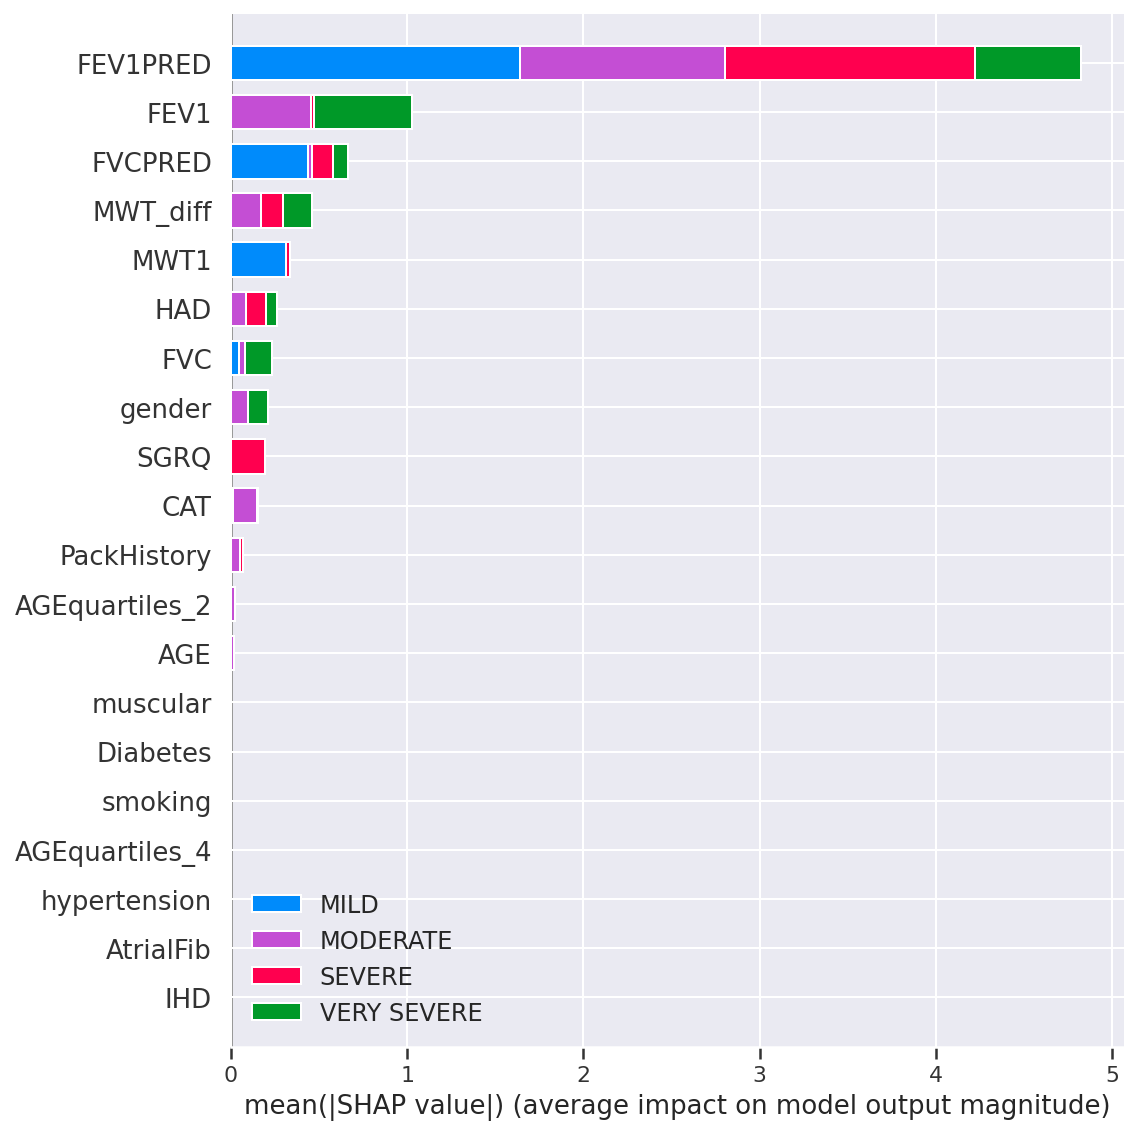

In [49]:
shap.summary_plot(explainer.shap_values(X_train_proc),
                  X_train_proc, feature_names=prep_pipe[-2].feature_names,
                  class_names=class_names
                 )

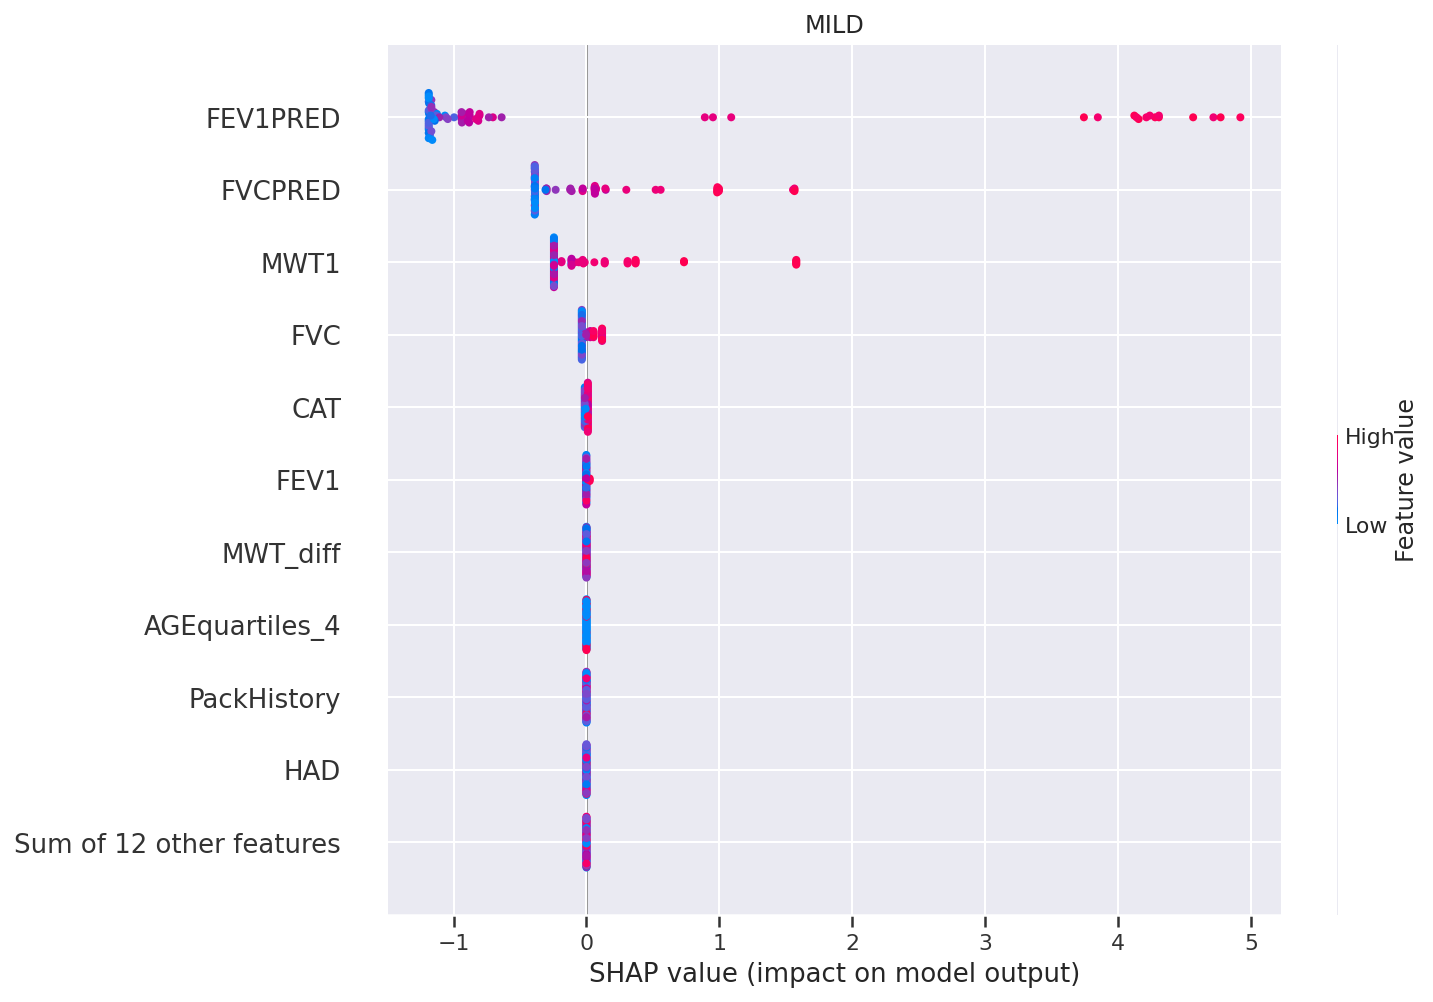

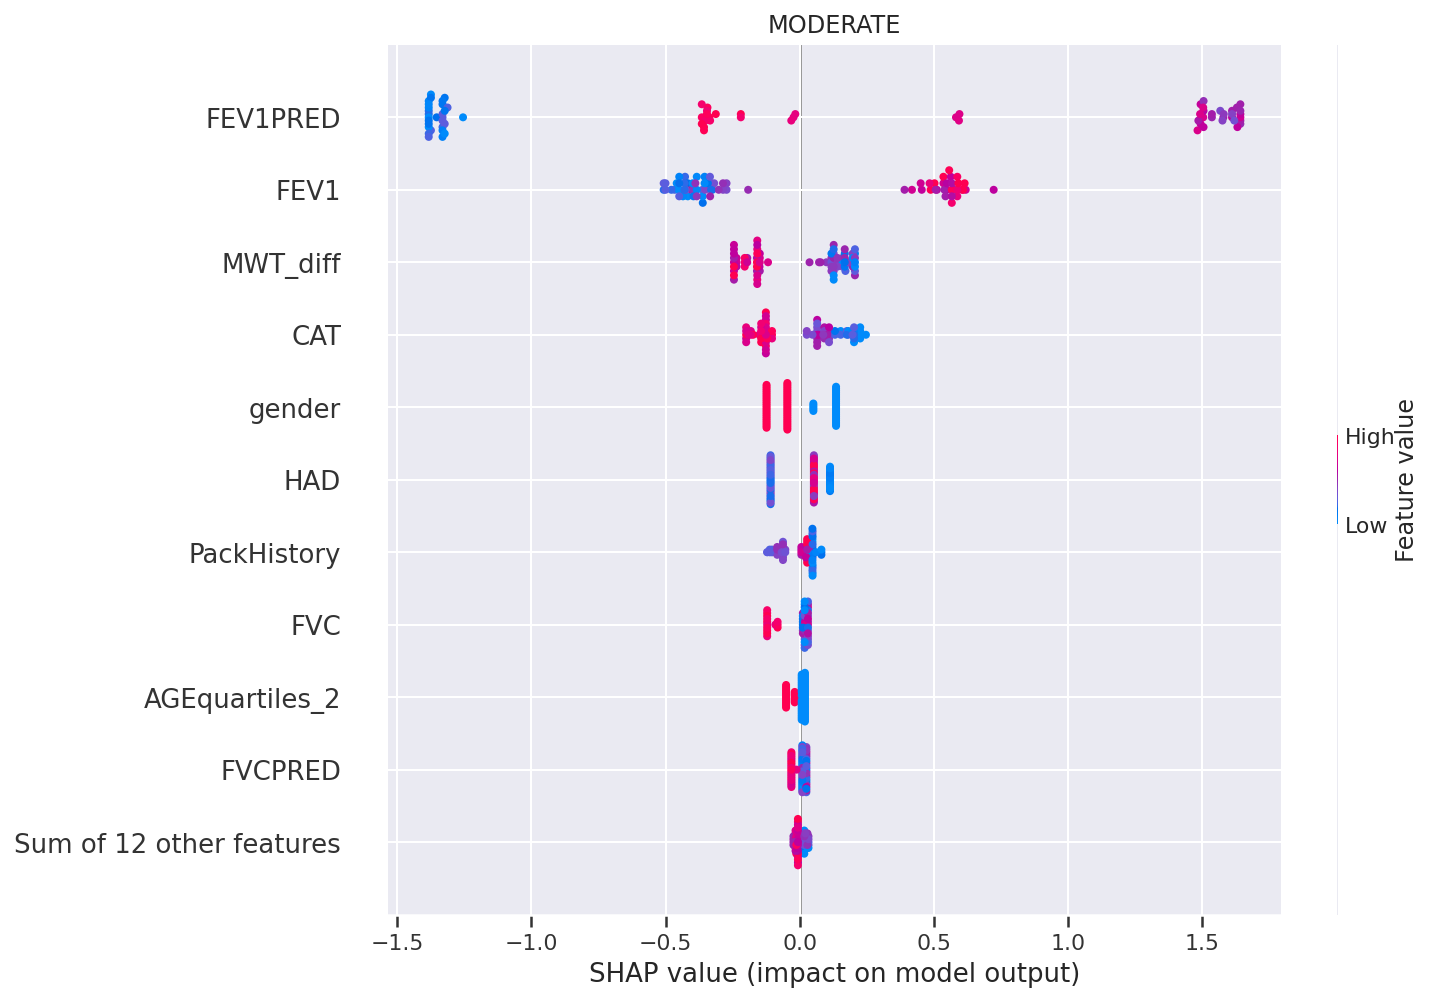

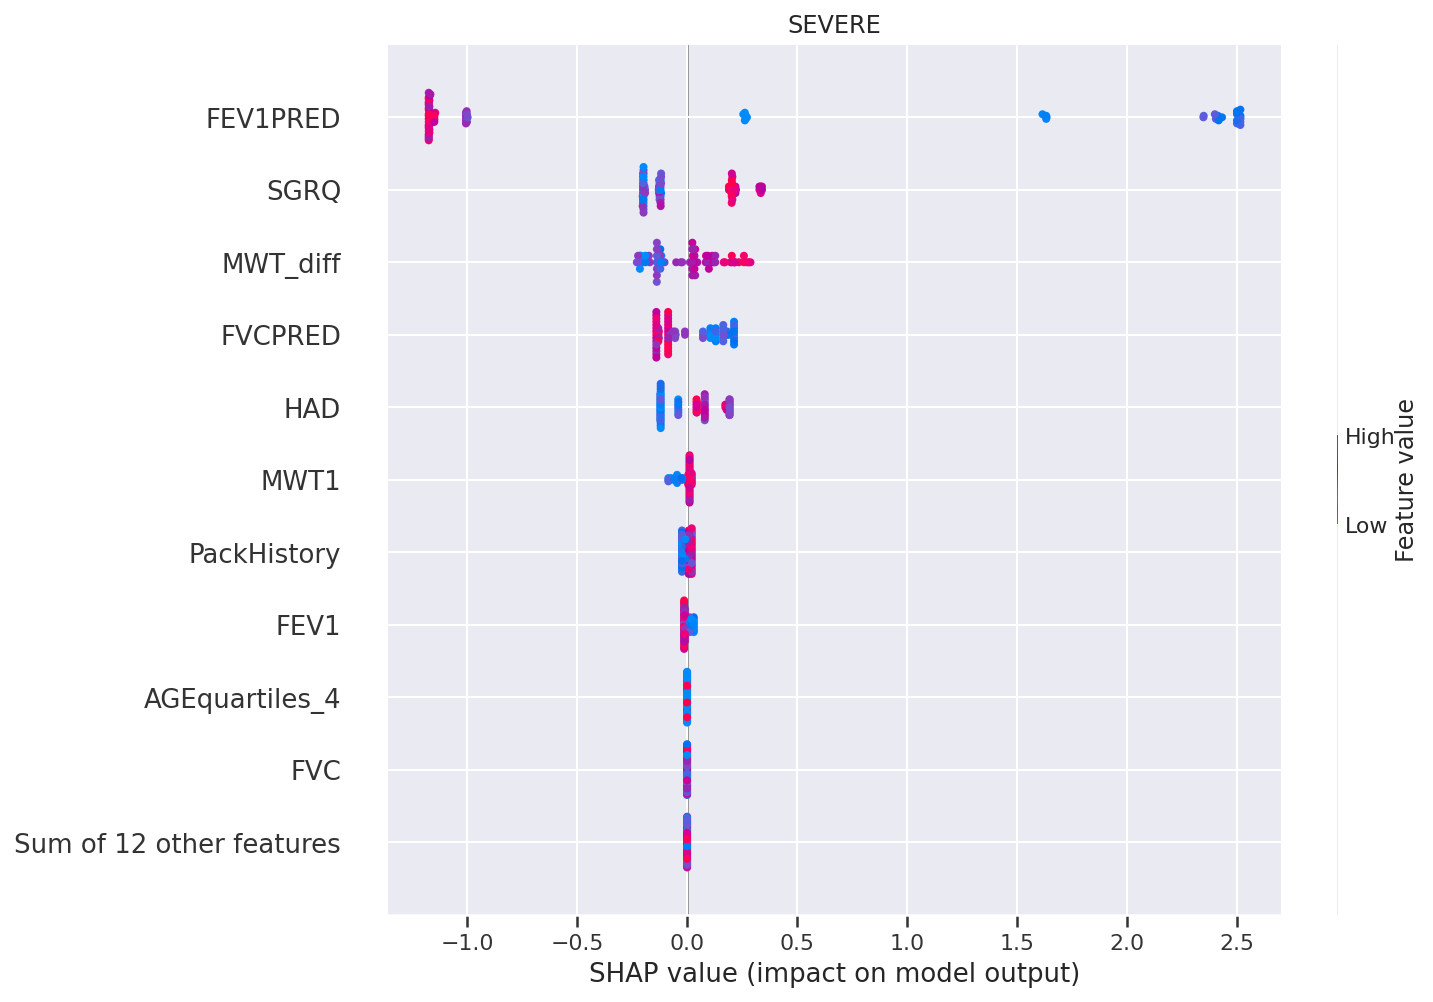

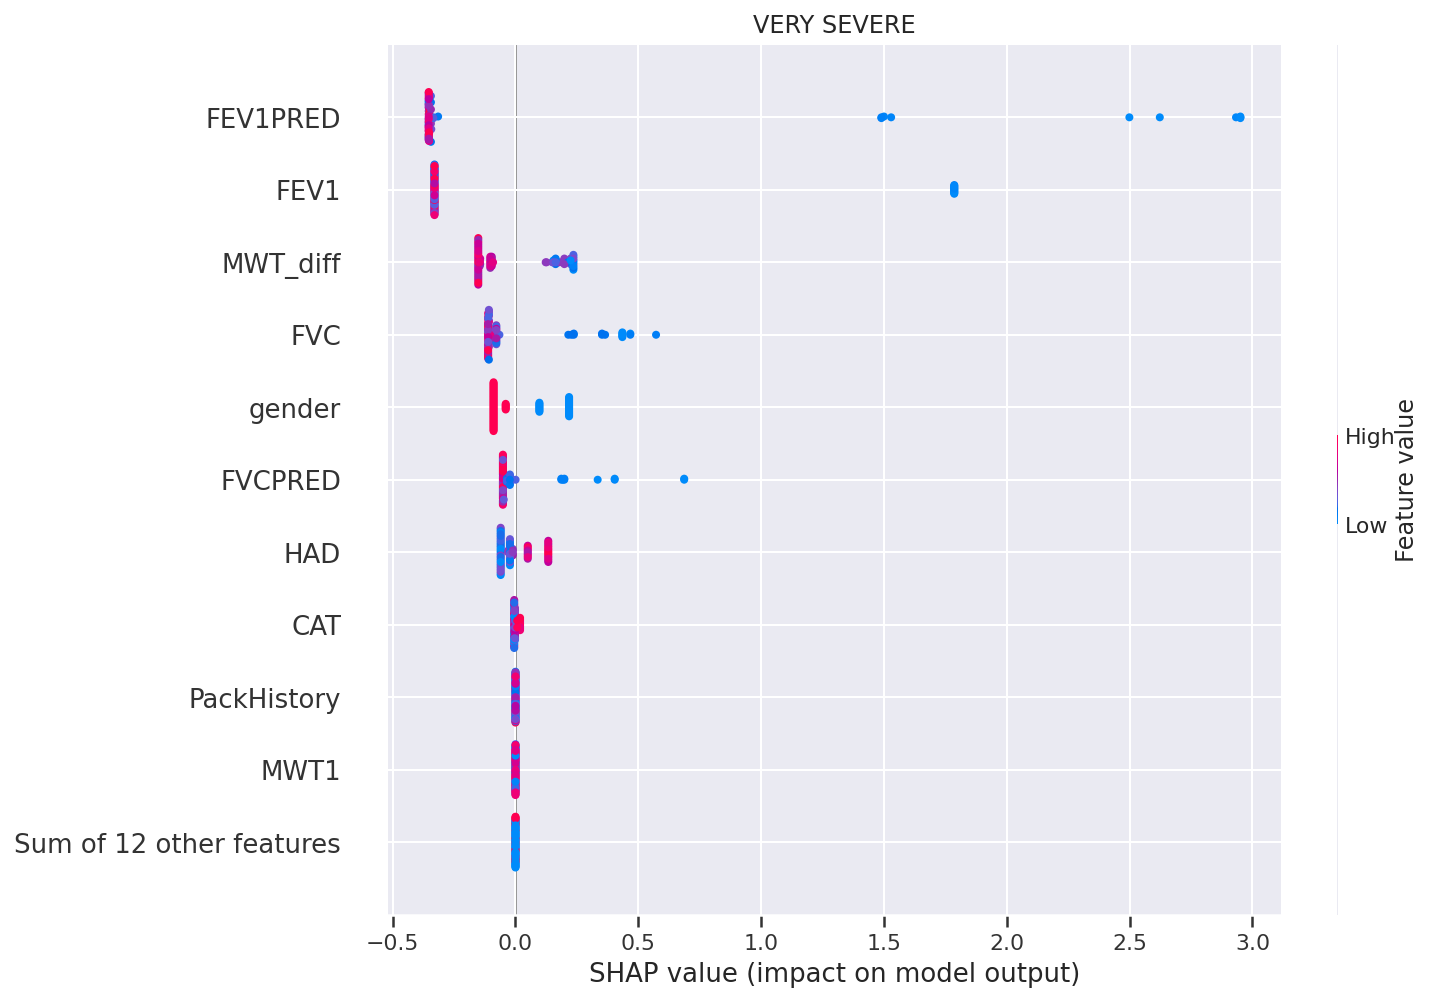

In [50]:
shap_values = explainer(pd.DataFrame(X_train_proc, columns=prep_pipe[-2].feature_names))
for idx, class_name in enumerate(class_names):
    shap_values_one_class = copy.deepcopy(shap_values)
    shap_values_one_class.values = shap_values_one_class.values[:,:,idx]
    shap_values_one_class.base_values = shap_values_one_class.base_values[:,idx]
    plt.title(class_name)
    shap.plots.beeswarm(shap_values_one_class, max_display=11, plot_size=(10,8))

Thus, `FEV1PRED` feature has  the highest impact on the final prediction and has the expected behaviour in the model. The less these values are, the more likely that a patient has severe or very severe COPD. The higher these values are, the more likely that a patient has mild COPD.

`FEV1` feature has high discriminative power for a moderate COPD.

The new added feature `MWT_diff` also has useful signal to separate moderate, sever and very severe COPD (2,3,4) 

With the growing number of observations it is better to get rid of non-informative features without any useful signal, retrain model and carefully recheck its metrcis. It helps in several ways, for example:

1. Less noise in the model input.
2. Faster model training and inference since number of features affects training and prediction time complexity.


Besides, most classifiers, especially neural networks, require calibration to associate confidences that a model outputs as a probability of a true classsification which can be extremely important in the task of medical diagnostics. However, this subtask requires more houldout data and, thus, it reduces the training subset.

<a id="onnxruntime"></a>
### Making onnx model for production

To store fitted model for production use, ONNX graph representation of models can be exploited.

In [51]:
def lgbm2onnx(sklearn_pipe, n_features, model_name, opset=10):
    
    update_registered_converter(
        lgb.LGBMClassifier, 'LightGbmLGBMClassifier',
        skl2onnx_shapecalc.calculate_linear_classifier_output_shapes, convert_lightgbm,
        options={'nocl': [True, False], 'zipmap': [True, False, 'columns']})

    model_onnx = convert_sklearn(
        model=sklearn_pipe, name=model_name,
        initial_types=[('input', skl2onnx_dtype.FloatTensorType([None, n_features]))],
        target_opset=opset
    )
    with open(f"{model_name}.onnx", "wb") as f:
        f.write(model_onnx.SerializeToString())

In [52]:
save_name = 'copd_classifier_lgbm_0.78_f1weighted'
lgbm2onnx(sklearn_pipe=best_model,
          n_features=X_train.shape[1],
          model_name=save_name)

In [53]:
model_sess = ort.InferenceSession(f"{save_name}.onnx")
pred_onnx_labels, pred_onnx_proba = model_sess.run(None, {"input": X_test.astype(np.float32)})

The ONNX-converted model results on test subset are expected to be equal to the classification report of an original model:

In [54]:
print('ONNXRuntime:\n', 
      classification_report(y_true=y_test, y_pred=pred_onnx_labels, target_names=class_names),
      '\nOriginal model:\n',
      classification_report(y_true=y_test, y_pred=best_model.predict(X_test), target_names=class_names))

ONNXRuntime:
               precision    recall  f1-score   support

        MILD       1.00      0.40      0.57         5
    MODERATE       0.73      1.00      0.84         8
      SEVERE       1.00      0.80      0.89         5
 VERY SEVERE       0.67      1.00      0.80         2

    accuracy                           0.80        20
   macro avg       0.85      0.80      0.78        20
weighted avg       0.86      0.80      0.78        20
 
Original model:
               precision    recall  f1-score   support

        MILD       1.00      0.40      0.57         5
    MODERATE       0.73      1.00      0.84         8
      SEVERE       1.00      0.80      0.89         5
 VERY SEVERE       0.67      1.00      0.80         2

    accuracy                           0.80        20
   macro avg       0.85      0.80      0.78        20
weighted avg       0.86      0.80      0.78        20

